# Loss Function Comparison

## Data Generation
- 90% of the time: small Gaussian noise N(0, 0.2²)
- 10% of the time: large asymmetric jump N(-1, 1²)
- Model: y = 1.5x + ε
- x ~ N(0, 1)

## Result

While OLS (MSE loss) achieves lower overall MSE by minimizing squared errors across all data points, Huber loss and MAE loss perform better on normal day. This demonstrates the trade-off:

- **Overall MSE:** OLS has the lowest MSE when including outliers, as it optimizes for this metric directly
- **Normal day performance:** Huber and MAE losses achieve lower MSE on typical data points by being more robust to outliers, which prevents them from being pulled away from the true relationship in the bulk of the data

Robust loss functions are preferred when outliers are present but you care more about accurate predictions for typical observations.

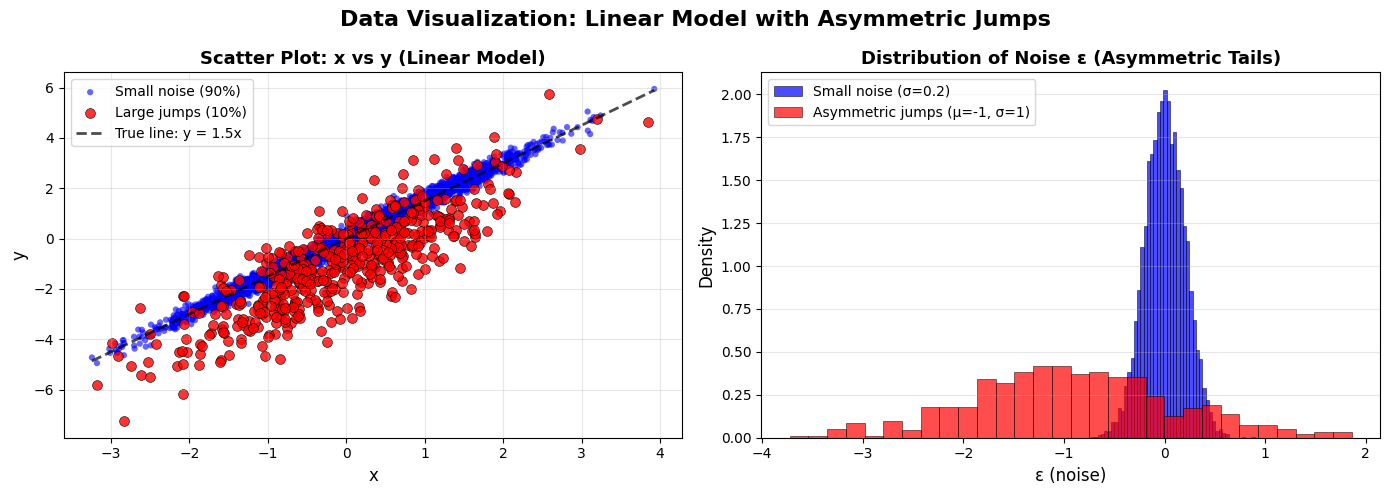

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# Parameters
n_samples = 5000
beta = 1.5  # Linear coefficient
sigma_small = 0.2
prob_jump = 0.1  # 10% chance of jump

# Generate data
x = np.random.normal(0, 1, n_samples)
jump = np.where(np.random.rand(n_samples) < prob_jump,
                np.random.normal(-1, 1, n_samples), 0)

# Small noise for all samples
noise = np.random.normal(0, sigma_small, n_samples)
epsilon = noise + jump
# Linear model: y = βx + ε
y = beta * x + epsilon

is_large = (jump != 0).astype(int)
df = pd.DataFrame({'x': x, 'y': y, 'epsilon': epsilon, 'jump': jump, 'is_large_jump': is_large})

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Data Visualization: Linear Model with Asymmetric Jumps', fontsize=16, fontweight='bold')

small_mask = df['is_large_jump'] == 0
large_mask = df['is_large_jump'] == 1

# Scatter plot
axes[0].scatter(df.loc[small_mask, 'x'], df.loc[small_mask, 'y'], 
                alpha=0.6, s=20, c='blue', label='Small noise (90%)', edgecolors='none')
axes[0].scatter(df.loc[large_mask, 'x'], df.loc[large_mask, 'y'], 
                alpha=0.8, s=50, c='red', label='Large jumps (10%)', edgecolors='black', linewidth=0.5)
x_line = np.linspace(df['x'].min(), df['x'].max(), 100)
y_true_line = beta * x_line
axes[0].plot(x_line, y_true_line, 'k--', linewidth=2, 
             label=f'True line: y = {beta}x', alpha=0.7)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title('Scatter Plot: x vs y (Linear Model)', fontsize=13, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(df.loc[small_mask, 'epsilon'], bins=50, alpha=0.7, color='blue', 
             label=f'Small noise (σ={sigma_small})', density=True, edgecolor='black', linewidth=0.5)
axes[1].hist(df.loc[large_mask, 'epsilon'], bins=30, alpha=0.7, color='red', 
             label=f'Asymmetric jumps (μ=-1, σ=1)', density=True, edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('ε (noise)', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Distribution of Noise ε (Asymmetric Tails)', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [155]:
from sklearn.linear_model import LinearRegression, HuberRegressor, QuantileRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error

poly = PolynomialFeatures(degree=1, include_bias=False)
X_poly = poly.fit_transform(x.reshape(-1, 1))

# Fit OLS (MSE loss)
ols_model = LinearRegression()
ols_model.fit(X_poly, y)
ols_coef = ols_model.coef_
ols_intercept = ols_model.intercept_

# Fit Huber loss
huber_model = HuberRegressor(epsilon=1)
huber_model.fit(X_poly, y)
huber_coef = huber_model.coef_
huber_intercept = huber_model.intercept_

# Fit MAE loss (QuantileRegressor with quantile=0.5 minimizes MAE)
mae_model = QuantileRegressor(quantile=0.5, alpha=0.0)  # alpha=0 for no regularization
mae_model.fit(X_poly, y)
mae_coef = mae_model.coef_
mae_intercept = mae_model.intercept_

# Generate predictions for all models
ols_pred = ols_model.predict(X_poly)
huber_pred = huber_model.predict(X_poly)
mae_pred = mae_model.predict(X_poly)

# Define tail mask based on OLS residuals (e.g., residuals in top/bottom 5%)
ols_residuals = y - ols_pred
residual_threshold = np.percentile(np.abs(ols_residuals), 95)
ols_tail_mask = np.abs(ols_residuals) > residual_threshold

print("=" * 80)
print("MODEL COMPARISON: MSE (OLS) vs Huber Loss vs MAE")
print("=" * 80)
print(f"\nTrue model: y = {beta:.2f}x + ε")
print(f"\nMSE (OLS) Model:")
print(f"  β_hat (linear): {ols_coef[0]:.4f}")
print(f"  Intercept: {ols_intercept:.4f}")
print(f"  MSE: {mean_squared_error(y, ols_pred):.4f}")
print(f"  MAE: {mean_absolute_error(y, ols_pred):.4f}")

print(f"\nHuber Loss Model:")
print(f"  β_hat (linear): {huber_coef[0]:.4f}")
print(f"  Intercept: {huber_intercept:.4f}")
print(f"  MSE: {mean_squared_error(y, huber_pred):.4f}")
print(f"  MAE: {mean_absolute_error(y, huber_pred):.4f}")

print(f"\nMAE (Quantile τ=0.5) Model:")
print(f"  β_hat (linear): {mae_coef[0]:.4f}")
print(f"  Intercept: {mae_intercept:.4f}")
print(f"  MSE: {mean_squared_error(y, mae_pred):.4f}")
print(f"  MAE: {mean_absolute_error(y, mae_pred):.4f}")

print("=" * 80)

MODEL COMPARISON: MSE (OLS) vs Huber Loss vs MAE

True model: y = 1.50x + ε

MSE (OLS) Model:
  β_hat (linear): 1.5082
  Intercept: -0.0901
  MSE: 0.2146
  MAE: 0.2663

Huber Loss Model:
  β_hat (linear): 1.5016
  Intercept: -0.0170
  MSE: 0.2199
  MAE: 0.2570

MAE (Quantile τ=0.5) Model:
  β_hat (linear): 1.5016
  Intercept: -0.0170
  MSE: 0.2199
  MAE: 0.2570


In [156]:
# Define middle data: not in tail AND not a jump day
middle_mask = ~(ols_tail_mask | df['is_large_jump'].astype(bool))

# Get predictions for middle data
ols_pred_middle = ols_pred[middle_mask]
huber_pred_middle = huber_pred[middle_mask]
mae_pred_middle = mae_pred[middle_mask]
y_middle = y[middle_mask]

# Calculate MSE for middle data
ols_mse_middle = mean_squared_error(y_middle, ols_pred_middle)
huber_mse_middle = mean_squared_error(y_middle, huber_pred_middle)
mae_mse_middle = mean_squared_error(y_middle, mae_pred_middle)


# Compare with overall MSE
print(f"\nComparison with Overall Performance:")
print(f"{'Metric':<35} {'OLS (MSE)':<20} {'Huber Loss':<20} {'MAE':<20}")
print("-" * 90)
print(f"{'MSE (all data)':<35} {mean_squared_error(y, ols_pred):<20.4f} {mean_squared_error(y, huber_pred):<20.4f} {mean_squared_error(y, mae_pred):<20.4f}")
print(f"{'MSE (middle only)':<35} {ols_mse_middle:<20.4f} {huber_mse_middle:<20.4f} {mae_mse_middle:<20.4f}")
print("=" * 90)


Comparison with Overall Performance:
Metric                              OLS (MSE)            Huber Loss           MAE                 
------------------------------------------------------------------------------------------
MSE (all data)                      0.2146               0.2199               0.2199              
MSE (middle only)                   0.0485               0.0403               0.0403              
